In [1]:
#import sys, os
#sys.path.append(os.path.expanduser('~/git/botop/build'))
#import libry as ry
from robotic import ry
import numpy as np
import time
import matplotlib.pyplot as plt
import quaternion

C = ry.Config()
C.addFile(ry.raiPath('../rai-robotModels/scenarios/pandasTable.g'))
#C.addFile(ry.raiPath('../rai-robotModels/scenarios/pandaSingle.g'))

cameraFrame = C.getFrame("camera")
cameraFrame.setPosition([0,-0.18,1.2])

boxSize = 0.07
heightFactor = 0.7
lengthFactor = 2.5

obj = C.addFrame('obj')
obj.setPose('t(0. 0.1 0.8)')
obj.setShape(ry.ST.ssBox, size=[boxSize,boxSize*lengthFactor,boxSize*heightFactor,.005])
obj.setColor([1,.0,0])
obj.setMass(.1)
obj.setContact(True)

# create a 5 by grid of black and white boxes that lie on the surface on the "obj" box and all together are the size of the box surface. The boxes are all quadratic and flat. 
# The color is given by this 2D array
color = [[0,0,0,0,0,0],[0,0,0,1,1,0],[0,0,0,1,1,0],[0,0,0,1,0,0],[0,1,1,0,1,0],[0,0,0,0,0,0]]
#create rotated color array
color = np.rot90(color, k=1, axes=(1, 0))

for i in range(6):
    for j in range(6):
        box = C.addFrame('box_'+str(i)+'_'+str(j), 'obj')
        #box.setShape(ry.ST.ssBox, size=[.01,.01,.001,.00])
        box.setShape(ry.ST.ssBox, size=[boxSize/6.0, boxSize/6.0, 0.001, 0.00])
        box.setColor([color[i][j],color[i][j],color[i][j]])
        box.setMass(0)
        box.setContact(False)
        #box.setRelativePose('t('+str(-0.02+0.01*i)+' '+str(-0.02+0.01*j)+' 0.025)')
        box.setRelativePose('t('+str(-boxSize/2.0+boxSize/12.0+boxSize/6.0*i)+' '+str(-boxSize/2.0+boxSize/12.0+boxSize/6.0*j)+' ' + str(heightFactor*boxSize/2.0) +  ')')


#cameraFrame = C.addFrame("myCamera")
#cameraFrame.setShape(ry.ST.marker, [0.3])
#cameraFrame.setPosition([0,0,2.0])
#cameraFrame.setPosition([0,1.0,2.0])
#cameraFrame.setQuaternion([1,-0.5,0,1])

C.view()

0

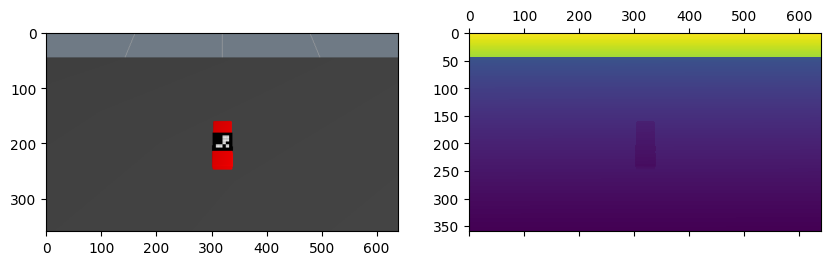

In [2]:
bot = ry.BotOp(C, False)
bot.home(C)

rgb, depth = bot.getImageAndDepth("camera")

fig = plt.figure(figsize=(10,5))
axs = fig.subplots(1, 2)
axs[0].imshow(rgb)
axs[1].matshow(depth)
plt.show()
import time
time.sleep(0.5)

From the lecture slides, we learned
$$\hat x = f\frac{X}{Z}+p_x,~\hat y = f\frac{Y}{Z}+p_y,$$
where
- $\hat x, \hat y$ are image coordinates ($u$-$v$ or pixel),
- $X, Y, Z$ represent camera coordinates, and
- $p_x, p_y$ are the image offset.

Since we know the $Z$ value of each pixel, we can compute their 3D coordinate (in camera frame):
$$ X = Z\frac{\hat x-p_x}{f},~  Y = Z\frac{\hat y-p_y}{f}.$$

In [3]:
fxypxy = bot.getCameraFxypxy("camera")
print(fxypxy)
depth.shape
cameraFrame = C.getFrame("camera")

#include opencv
import cv2

# open webcam
cap = rgb
x = 0
y = 0

aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
aruco_params =  cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, aruco_params)


# loop through frames
#while True:
# read frame from webcam
frame = rgb
# convert frame to grayscale
gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
# detect aruco markers
corners, ids, rejected = detector.detectMarkers(gray)
#print(ids)
# draw markers on frame
frame = cv2.aruco.drawDetectedMarkers(frame, corners, ids)
# get camera pose

# define dummy values for camera matrix and distortion coefficients
cameraMatrix = np.array([[fxypxy[0], 0, fxypxy[2]], [0, fxypxy[1], fxypxy[3]], [0, 0, 1]])

# define a wrogn camera matrix with nonsense values
distCoeffs = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

rvec, tvec, markerPoints = cv2.aruco.estimatePoseSingleMarkers(corners, boxSize, cameraMatrix,
                                                                           distCoeffs)
(rvec - tvec).any()  # get rid of that nasty numpy value array error
cv2.aruco.drawDetectedMarkers(frame, corners)  # Draw A square around the markers
cv2.drawFrameAxes(frame, cameraMatrix, distCoeffs, rvec, tvec, 0.01)  # Draw Axis

cameraDistanceFactor = -1.0
print('t(' + str(tvec[0][0][0]) + ' ' + str(tvec[0][0][1]) + ' ' + str(tvec[0][0][2]) + ') r(' + str(rvec[0][0][0]) + ' ' + str(rvec[0][0][1]) + ' ' + str(rvec[0][0][2]) + ')')

arucoPoint = [cameraDistanceFactor*tvec[0][0][0], cameraDistanceFactor*tvec[0][0][1], cameraDistanceFactor*tvec[0][0][2]]

q = quaternion.from_rotation_vector(rvec)

q = quaternion.as_euler_angles(q)
#q[0][0][2] = -q[0][0][2]


q = quaternion.from_euler_angles(q)

b = quaternion.as_float_array([q])

arucoQuaternion = b[0]



C.view()
#get center of marker
print(ids)
if ids is not None:
    for i in range(len(ids)):
        c = corners[i][0]
        x = int((c[0][0] + c[1][0] + c[2][0] + c[3][0])/4)
        y = int((c[0][1] + c[1][1] + c[2][1] + c[3][1])/4)
        cv2.circle(frame, (x, y), 4, (0, 0, 255), -1)
        #calculate width of the marker in pixel space
        w = int(c[2][0] - c[0][0])
        #calculate height in pixel space
        h = int(c[2][1] - c[0][1])
        # print out all elements of c
        print(c)
# get center from 2 markers
if ids is not None:
    if len(ids) == 2:
        c1 = corners[0][0]
        c2 = corners[1][0]
        x = int((c1[0][0] + c1[1][0] + c1[2][0] + c1[3][0] + c2[0][0] + c2[1][0] + c2[2][0] + c2[3][0])/8)
        y = int((c1[0][1] + c1[1][1] + c1[2][1] + c1[3][1] + c2[0][1] + c2[1][1] + c2[2][1] + c2[3][1])/8)
        cv2.circle(frame, (x, y), 4, (0, 0, 255), -1)
        

# display frame
#cv2.imshow('frame', frame)
# check if user pressed 'q'
#cv2.waitKey(0)
print(x,y)
print(w,h)

#cv2.destroyAllWindows()
#del bot
#del C

[322.19998169 322.19998169 320.         180.        ]
t(-0.0009697581105315702 0.03414816260863574 0.6270583906582026) r(2.6087391685314696 -0.0004837970049569627 0.002242754071078322)
[[2]]
[[302. 182.]
 [337. 182.]
 [338. 214.]
 [301. 214.]]
319 198
36 32


In [4]:
fx, fy = fxypxy[0], fxypxy[1]
px, py = fxypxy[2], fxypxy[3]
R, t = cameraFrame.getRotationMatrix(), cameraFrame.getPosition()
H, W = depth.shape

    
Z = depth[x,y]

point = [1, 2, 3]
Z += (h/ fx)*0.5

## depth is sign-fliped, j: right, i: down
point[0] = Z * (x - px) / fx;
point[1] = -Z * (y - py) / fy;
point[2] = -Z

h = Z * (h);
w = Z * w

tmp = C.addFrame( "center of red", 'camera')
tmp.setShape(ry.ST.ssBox, size=[(w/ fx),(lengthFactor*h/ fy),(heightFactor*w/ fx),.005])
tmp.setColor([1,0,0,.5])

tmp.setRelativePosition(arucoPoint)


tmp.setRelativeQuaternion(arucoQuaternion)
C.view()

0

In [5]:
# manually define frames as an endeff waypoints, relative to box:
way0 = C.addFrame('way0', 'center of red')
way1 = C.addFrame('way1', 'center of red')
way2 = C.addFrame('way2', 'center of red')
way2.setShape(ry.ST.marker, size=[.5])
way2.setRelativePose('t(0 0 .3) d(180 1 0 0)')

way0.setShape(ry.ST.marker, size=[.1])
way0.setRelativePose('t(0 0 -.2)  d(180 1 0 0)')
#way0.setRelativePose('t(0 0 .1)')

way1.setShape(ry.ST.marker, size=[.1])
way1.setRelativePose(' d(180 1 0 0)')

C.view()
print("dome")

komo = ry.KOMO()
komo.setConfig(C, True)
komo.setTiming(2., 1, 5., 0)
komo.addControlObjective([], 0, 1e-0)
komo.addObjective([], ry.FS.accumulatedCollisions, [], ry.OT.eq);
komo.addObjective([], ry.FS.jointLimits, [], ry.OT.ineq);
#komo.addObjective([1.], ry.FS.scalarProductXZ, ['l_gripper','way0'], ry.OT.eq, [1e1]);
komo.addObjective([1.], ry.FS.poseDiff, ['l_gripper', 'way0'], ry.OT.eq, [1e1]);
komo.addObjective([2.], ry.FS.poseDiff, ['l_gripper', 'way1'], ry.OT.eq, [1e1]);

ret = ry.NLP_Solver() \
    .setProblem(komo.nlp()) \
    .setOptions( stopTolerance=1e-2, verbose=4 ) \
    .solve()
print(ret)

komo.view(False, "waypoints solution")

komo.view_close()
path = komo.getPath()

bot = ry.BotOp(C, False)

input("press ENTER to move to home position")

bot.home(C)
    

bot.gripperOpen(ry._left)
while not bot.gripperDone(ry._left):
    bot.sync(C, .1)
    
input("press ENTER to move to gripping pose")
bot.move(path, [10])
while bot.getTimeToEnd()>0:
    bot.sync(C, .1)
    
input("press ENTER to close gripper")
bot.gripperClose(ry._left)
while not bot.gripperDone(ry._left):
    bot.sync(C, .1)
    
input("press ENTER to move to home position")
bot.home(C)

input("press ENTER to open gripper")
bot.gripperOpen(ry._left)
while not bot.gripperDone(ry._left):
    bot.sync(C, .1)

dome
====nlp==== method:AugmentedLagrangian bounded: yes
==nlp== it:0 evals:0 mu:1 nu:1 muLB:0.1
{ time: 0.006059, evals: 13, done: 1, feasible: 1, sos: 2.27097, f: 0, ineq: 0, eq: 0.0114575 }
----newton---- initial point f(x):90.5767 alpha:1 beta:1
--newton-- it:   1  |Delta|:        0.2  alpha:          1  evals:   2  f(y):    57.3644  ACCEPT
--newton-- it:   2  |Delta|:        0.2  alpha:          1  evals:   3  f(y):    25.0849  ACCEPT
--newton-- it:   3  |Delta|:        0.2  alpha:          1  evals:   4  f(y):    9.64523  ACCEPT
--newton-- it:   4  |Delta|:        0.2  alpha:          1  evals:   5  f(y):    4.48217  ACCEPT
--newton-- it:   5  |Delta|:        0.2  alpha:          1  evals:   6  f(y):    2.43893  ACCEPT
--newton-- it:   6  |Delta|:   0.125153  alpha:          1  evals:   7  f(y):    2.06102  ACCEPT
--newton-- it:   7  |Delta|:  0.0466412  alpha:          1  evals:   8  f(y):    2.03694  ACCEPT
--newton-- it:   8  |Delta|:  0.0152812  alpha:          1  evals:   9 

In [ ]:
C.delFrame('pcl')

In [ ]:
bot.sync(C)

In [ ]:
cv2.destroyAllWindows()
del bot
del C